In [3]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification, 
    AdamW,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
from tqdm import tqdm
import pickle
import os
import nltk
from nltk import pos_tag, word_tokenize
from time import time
from sklearn.metrics import classification_report

# Download required NLTK data
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

print("All imports successful!")

All imports successful!


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\YASH\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\YASH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# Cell 2: Data Loading and Enhanced Preprocessing
# Load dataset
df = pd.read_csv('Tweets.csv')

def clean_text_with_pos(text):
    """
    Clean text and add POS tags to words
    Returns: cleaned text with POS tags
    Example: "I love this" -> "I_PRON love_VERB this_DET"
    """
    # Basic cleaning
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.strip()
    
    # POS tagging
    try:
        tokens = word_tokenize(text)
        tagged = pos_tag(tokens)
        
        # Simplify POS tags
        simplified_tags = []
        for word, tag in tagged:
            if tag.startswith('NN'):  # Nouns
                simplified_tag = 'NOUN'
            elif tag.startswith('VB'):  # Verbs
                simplified_tag = 'VERB'
            elif tag.startswith('JJ'):  # Adjectives
                simplified_tag = 'ADJ'
            elif tag.startswith('RB'):  # Adverbs
                simplified_tag = 'ADV'
            elif tag.startswith('PRP'):  # Pronouns
                simplified_tag = 'PRON'
            elif tag.startswith('DT'):  # Determiners
                simplified_tag = 'DET'
            else:
                simplified_tag = 'OTHER'
            
            simplified_tags.append(f"{word}_{simplified_tag}")
        
        return ' '.join(simplified_tags)
    except Exception as e:
        print(f"Error in POS tagging: {e}")
        return text

# Apply enhanced cleaning with POS tags
print("Starting text preprocessing with POS tagging...")
df['cleaned_text'] = df['text'].apply(clean_text_with_pos)

# Create and fit label encoder
label_encoder = LabelEncoder()
df['encoded_sentiment'] = label_encoder.fit_transform(df['airline_sentiment'])  # Changed from 'sentiment' to 'airline_sentiment'

# Print sample of processed text
print("\nSample processed texts with POS tags:")
for i in range(3):
    print(f"\nOriginal: {df['text'].iloc[i][:100]}")
    print(f"Processed: {df['cleaned_text'].iloc[i][:100]}")

# Print sentiment distribution
print("\nSentiment Distribution:")
print(df['airline_sentiment'].value_counts())

print("\nData preprocessing completed!")
print(f"Total samples: {len(df)}")
print(f"Unique sentiments: {df['airline_sentiment'].unique()}")

# Verify columns
print("\nDataframe columns:", df.columns.tolist())

Starting text preprocessing with POS tagging...

Sample processed texts with POS tags:

Original: @VirginAmerica What @dhepburn said.
Processed: What_OTHER said_VERB

Original: @VirginAmerica plus you've added commercials to the experience... tacky.
Processed: plus_OTHER youve_NOUN added_ADJ commercials_NOUN to_OTHER the_DET experience_NOUN tacky_NOUN

Original: @VirginAmerica I didn't today... Must mean I need to take another trip!
Processed: I_PRON didnt_VERB today_NOUN Must_NOUN mean_NOUN I_PRON need_VERB to_OTHER take_VERB another_DET tri

Sentiment Distribution:
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

Data preprocessing completed!
Total samples: 14640
Unique sentiments: ['neutral' 'positive' 'negative']

Dataframe columns: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 

In [10]:
# Cell 3: Dataset Class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        # Convert to list to avoid pandas indexing issues
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])  # Using iloc for pandas Series
        label = self.labels.iloc[idx]     # Using iloc for pandas Series
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Verify the dataset class
print("Dataset class defined successfully!")

# Optional: Print the label encoding mapping
print("\nLabel Encoding Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

# Test the dataset class
print("\nTesting dataset creation...")
sample_texts = df['cleaned_text'][:5]
sample_labels = df['encoded_sentiment'][:5]
sample_dataset = TweetDataset(sample_texts, sample_labels, tokenizer)
print(f"Sample dataset size: {len(sample_dataset)}")
print("Testing data loading...")
sample_item = sample_dataset[0]
print("Dataset test successful!")

Dataset class defined successfully!

Label Encoding Mapping:
negative: 0
neutral: 1
positive: 2

Testing dataset creation...
Sample dataset size: 5
Testing data loading...
Dataset test successful!


In [8]:
# Cell 4: Training Function
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    correct_predictions = 0
    total_predictions = 0
    
    progress_bar = tqdm(data_loader, desc="Training")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Clear previous gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # Calculate accuracy
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += len(labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Store loss
        losses.append(loss.item())
        
        # Update progress bar
        progress_bar.set_postfix({'loss': np.mean(losses)})
    
    # Calculate epoch metrics
    epoch_loss = np.mean(losses)
    epoch_accuracy = correct_predictions.double() / total_predictions
    
    return epoch_accuracy, epoch_loss

def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            _, preds = torch.max(logits, dim=1)
            
            correct_predictions += torch.sum(preds == labels)
            total_predictions += len(labels)
            
            losses.append(loss.item())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            progress_bar.set_postfix({'loss': np.mean(losses)})
    
    # Calculate metrics
    epoch_loss = np.mean(losses)
    epoch_accuracy = correct_predictions.double() / total_predictions
    
    # Generate classification report
    report = classification_report(
        all_labels, 
        all_preds, 
        target_names=label_encoder.classes_,
        digits=4
    )
    
    return epoch_accuracy, epoch_loss, report

print("Training and evaluation functions defined successfully!")
print("\nThese functions will:")
print("1. Train the model with POS-tagged text")
print("2. Track accuracy and loss")
print("3. Generate detailed evaluation metrics")
print("4. Show progress bars during training")

Training and evaluation functions defined successfully!

These functions will:
1. Train the model with POS-tagged text
2. Track accuracy and loss
3. Generate detailed evaluation metrics
4. Show progress bars during training


In [11]:
# Cell 5: Model Setup and Training
print("Starting model setup and training...")

# Initialize tokenizer and model
print("\n1. Initializing tokenizer and model...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(label_encoder.classes_)
)

# Split data
print("\n2. Splitting data into train and test sets...")
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned_text'],
    df['encoded_sentiment'],
    test_size=0.2,
    random_state=42
)
print(f"Training samples: {len(train_texts)}")
print(f"Testing samples: {len(test_texts)}")

# Create datasets
print("\n3. Creating datasets...")
train_dataset = TweetDataset(train_texts, train_labels, tokenizer)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer)

# Create data loaders
print("\n4. Creating data loaders...")
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n5. Using device: {device}")
model = model.to(device)

# Setup optimizer and scheduler
print("\n6. Setting up optimizer and scheduler...")
optimizer = AdamW(model.parameters(), lr=2e-5)
num_training_steps = len(train_loader) * 2  # 2 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Training loop
print("\n7. Starting training...")
best_accuracy = 0
for epoch in range(2):
    print(f'\nEpoch {epoch + 1}/2')
    
    # Training
    train_acc, train_loss = train_epoch(
        model, train_loader, optimizer, scheduler, device
    )
    print(f'Train accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}')
    
    # Evaluation
    val_acc, val_loss, classification_rep = eval_model(model, test_loader, device)
    print(f'Validation accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}')
    print("\nClassification Report:")
    print(classification_rep)
    
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        print("\nSaving best model...")
        torch.save(model.state_dict(), 'best_model_state.bin')
        print("Model saved successfully!")

# Save label encoder
print("\n8. Saving label encoder...")
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)
print("Label encoder saved successfully!")

# Final verification
print("\n9. Checking saved files:")
print(f"Model file exists: {os.path.exists('best_model_state.bin')}")
print(f"Label encoder exists: {os.path.exists('label_encoder.pkl')}")
print(f"Files are saved in: {os.getcwd()}")

print("\nTraining completed successfully!")

Starting model setup and training...

1. Initializing tokenizer and model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\YASH\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



2. Splitting data into train and test sets...
Training samples: 11712
Testing samples: 2928

3. Creating datasets...

4. Creating data loaders...

5. Using device: cpu

6. Setting up optimizer and scheduler...

7. Starting training...

Epoch 1/2


Training: 100%|███████████████████████████████████████████████████████████| 732/732 [45:35<00:00,  3.74s/it, loss=0.58]


Train accuracy: 0.7698, Loss: 0.5804


Evaluating: 100%|████████████████████████████████████████████████████████| 183/183 [03:34<00:00,  1.17s/it, loss=0.442]


Validation accuracy: 0.8347, Loss: 0.4420

Classification Report:
              precision    recall  f1-score   support

    negative     0.8872    0.9201    0.9033      1889
     neutral     0.6964    0.5931    0.6406       580
    positive     0.7621    0.7887    0.7752       459

    accuracy                         0.8347      2928
   macro avg     0.7819    0.7673    0.7730      2928
weighted avg     0.8298    0.8347    0.8312      2928


Saving best model...
Model saved successfully!

Epoch 2/2


Training: 100%|███████████████████████████████████████████████████████████| 732/732 [46:36<00:00,  3.82s/it, loss=0.39]


Train accuracy: 0.8503, Loss: 0.3901


Evaluating: 100%|████████████████████████████████████████████████████████| 183/183 [03:34<00:00,  1.17s/it, loss=0.429]


Validation accuracy: 0.8391, Loss: 0.4291

Classification Report:
              precision    recall  f1-score   support

    negative     0.8921    0.9195    0.9056      1889
     neutral     0.7097    0.6155    0.6593       580
    positive     0.7594    0.7908    0.7748       459

    accuracy                         0.8391      2928
   macro avg     0.7871    0.7753    0.7799      2928
weighted avg     0.8352    0.8391    0.8363      2928


Saving best model...
Model saved successfully!

8. Saving label encoder...
Label encoder saved successfully!

9. Checking saved files:
Model file exists: True
Label encoder exists: True
Files are saved in: C:\Users\YASH\MINI-PROJECT_sem 2\trail new mini

Training completed successfully!


In [17]:
# Run this in a cell first to check if we can proceed
print("Checking required variables:")
print(f"Model loaded: {'model' in globals()}")
print(f"Test loader ready: {'test_loader' in globals()}")
print(f"Device configured: {'device' in globals()}")
print(f"Label encoder available: {'label_encoder' in globals()}")

if all(var in globals() for var in ['model', 'test_loader', 'device', 'label_encoder']):
    print("\n✅ All required variables are available. Ready to run evaluation!")
else:
    print("\n❌ Some required variables are missing. Please make sure training was completed successfully.")

Checking required variables:
Model loaded: True
Test loader ready: True
Device configured: True
Label encoder available: True

✅ All required variables are available. Ready to run evaluation!


Starting evaluation process...

Step 1: Getting predictions...

Generating predictions... This may take a few minutes.
Processing batch 10/183 (5.5%) - Elapsed time: 11.5s
Processing batch 20/183 (10.9%) - Elapsed time: 23.4s
Processing batch 30/183 (16.4%) - Elapsed time: 35.8s
Processing batch 40/183 (21.9%) - Elapsed time: 48.9s
Processing batch 50/183 (27.3%) - Elapsed time: 61.4s
Processing batch 60/183 (32.8%) - Elapsed time: 73.0s
Processing batch 70/183 (38.3%) - Elapsed time: 84.8s
Processing batch 80/183 (43.7%) - Elapsed time: 96.6s
Processing batch 90/183 (49.2%) - Elapsed time: 109.4s
Processing batch 100/183 (54.6%) - Elapsed time: 120.7s
Processing batch 110/183 (60.1%) - Elapsed time: 131.9s
Processing batch 120/183 (65.6%) - Elapsed time: 144.7s
Processing batch 130/183 (71.0%) - Elapsed time: 158.7s
Processing batch 140/183 (76.5%) - Elapsed time: 171.5s
Processing batch 150/183 (82.0%) - Elapsed time: 184.8s
Processing batch 160/183 (87.4%) - Elapsed time: 197.7s
Pro

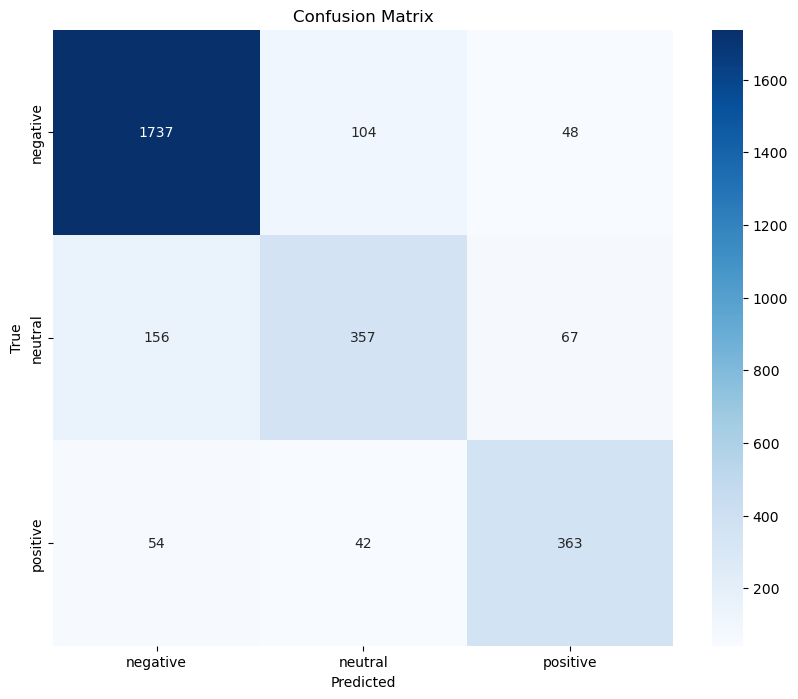


Step 3: Generating Classification Report:
              precision    recall  f1-score   support

    negative     0.8921    0.9195    0.9056      1889
     neutral     0.7097    0.6155    0.6593       580
    positive     0.7594    0.7908    0.7748       459

    accuracy                         0.8391      2928
   macro avg     0.7871    0.7753    0.7799      2928
weighted avg     0.8352    0.8391    0.8363      2928


Step 4: Calculating Detailed Metrics:
Accuracy: 0.8391
Macro F1-Score: 0.7799

Per-Class Precision:
negative: 0.8921
neutral: 0.7097
positive: 0.7594

Step 5: Saving Results...
✓ Confusion matrix saved as 'confusion_matrix.png'
✓ Metrics saved to 'model_metrics.json'

Evaluation process completed successfully!


<Figure size 640x480 with 0 Axes>

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import torch
from tqdm import tqdm
import json
import numpy as np
import time

print("Starting evaluation process...")

def plot_confusion_matrix(y_true, y_pred, labels):
    print("Creating confusion matrix plot...")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return cm

def get_predictions(model, test_loader, device):
    print("\nGenerating predictions... This may take a few minutes.")
    start_time = time.time()
    model.eval()
    all_preds = []
    all_labels = []
    total_batches = len(test_loader)
    
    with torch.no_grad():
        for i, batch in enumerate(test_loader, 1):
            if i % 10 == 0:
                elapsed_time = time.time() - start_time
                print(f"Processing batch {i}/{total_batches} ({(i/total_batches)*100:.1f}%) - Elapsed time: {elapsed_time:.1f}s")
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    total_time = time.time() - start_time
    print(f"\nPrediction generation completed in {total_time:.1f} seconds")
    return all_labels, all_preds

# Main execution
try:
    print("\nStep 1: Getting predictions...")
    true_labels, predicted_labels = get_predictions(model, test_loader, device)

    print("\nStep 2: Creating visualizations and metrics...")
    cm = plot_confusion_matrix(
        true_labels, 
        predicted_labels, 
        labels=label_encoder.classes_
    )

    print("\nStep 3: Generating Classification Report:")
    report = classification_report(
        true_labels, 
        predicted_labels, 
        target_names=label_encoder.classes_,
        digits=4
    )
    print(report)

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    print("\nStep 4: Calculating Detailed Metrics:")
    accuracy = accuracy_score(true_labels, predicted_labels)
    macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-Score: {macro_f1:.4f}")
    print("\nPer-Class Precision:")
    for i, label in enumerate(label_encoder.classes_):
        precision = precision_score(true_labels, predicted_labels, labels=[i], average='micro')
        print(f"{label}: {precision:.4f}")

    print("\nStep 5: Saving Results...")
    plt.savefig('confusion_matrix.png')
    print("✓ Confusion matrix saved as 'confusion_matrix.png'")

    metrics = {
        "accuracy": float(accuracy),
        "macro_f1": float(macro_f1),
        "classification_report": report,
        "per_class_precision": {
            label: float(precision_score(true_labels, predicted_labels, labels=[i], average='micro'))
            for i, label in enumerate(label_encoder.classes_)
        }
    }

    with open('model_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=4)
    print("✓ Metrics saved to 'model_metrics.json'")

    print("\nEvaluation process completed successfully!")

except Exception as e:
    print(f"\n❌ An error occurred: {str(e)}")

In [20]:
   # Run this after evaluation completes to verify files
   import os
   
   files_needed = {
       'best_model_state.bin': 'Model weights file',
       'label_encoder.pkl': 'Label encoder file',
       'app.py': 'Streamlit application file',
       'confusion_matrix.png': 'Evaluation visualization',
       'model_metrics.json': 'Model performance metrics'
   }
   
   print("Checking required files:")
   for file, description in files_needed.items():
       exists = os.path.exists(file)
       status = "✅" if exists else "❌"
       print(f"{status} {file}: {description}")

Checking required files:
✅ best_model_state.bin: Model weights file
✅ label_encoder.pkl: Label encoder file
✅ app.py: Streamlit application file
✅ confusion_matrix.png: Evaluation visualization
✅ model_metrics.json: Model performance metrics
